In [ ]:
!pip install einops


100%|██████████| 170M/170M [00:18<00:00, 8.98MB/s]


Extracting ./cifar-10-python.tar.gz to .


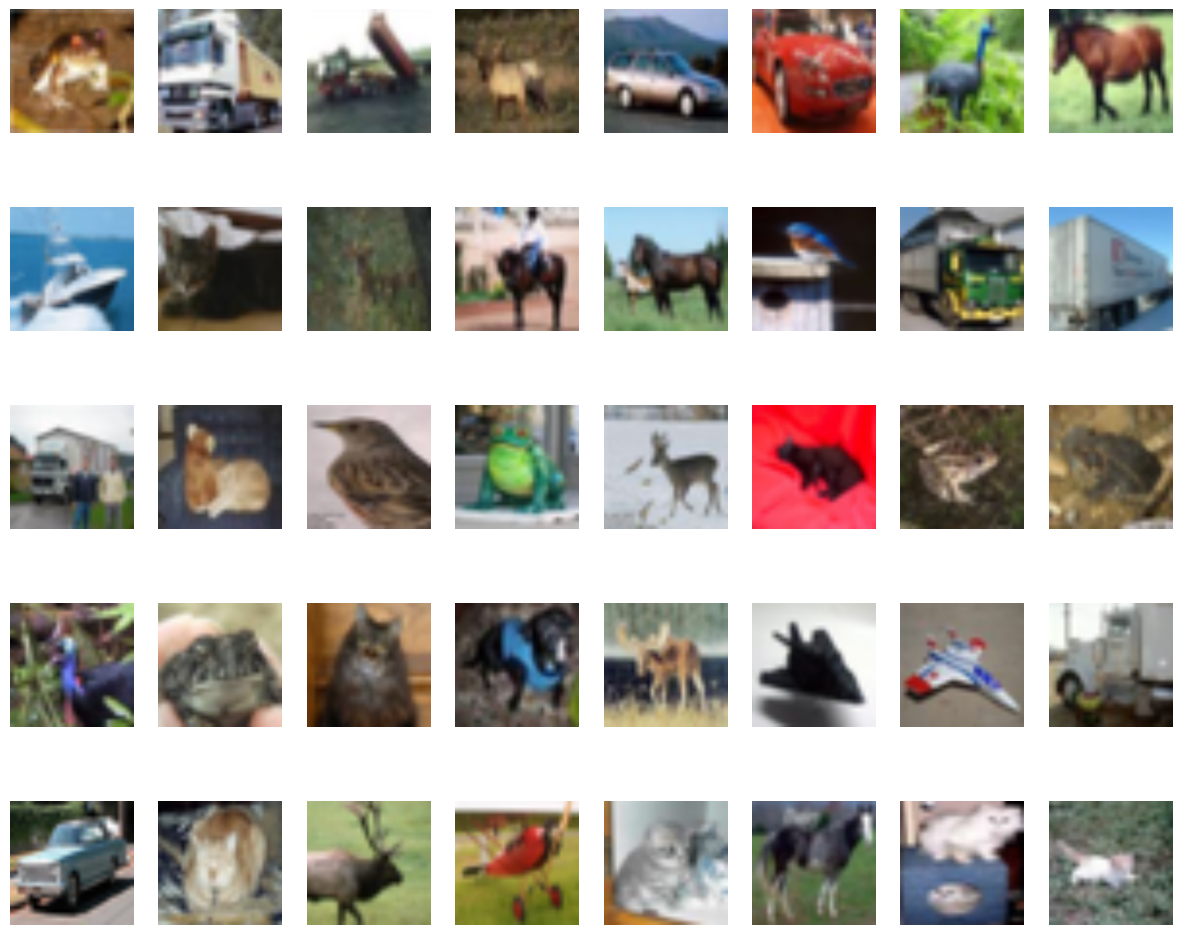

In [ ]:
import torch
from torchvision.datasets import CIFAR10
import matplotlib.pyplot as plt
from torchvision.transforms import Compose, Resize, ToTensor
from torchvision.transforms.functional import to_pil_image

# Define transformations
to_tensor = Compose([Resize((144, 144)), ToTensor()])

# Function to display images
def show_images(dataset, num_samples=40, cols=8):
    """ Plots some samples from the dataset """
    plt.figure(figsize=(15, 15))
    for i in range(num_samples):
        img, _ = dataset[i]
        plt.subplot(int(num_samples / cols) + 1, cols, i + 1)
        plt.imshow(to_pil_image(img))
        plt.axis("off")
    plt.show()

# Load CIFAR-10 dataset
dataset = CIFAR10(root=".", download=True, transform=to_tensor)

# Show sample images
show_images(dataset)


In [ ]:
from torch import nn
from einops.layers.torch import Rearrange
from torch import Tensor


class PatchEmbedding(nn.Module):
    def __init__(self, in_channels = 3, patch_size = 8, emb_size = 128):
        self.patch_size = patch_size
        super().__init__()
        self.projection = nn.Sequential(

            Rearrange('b c (h p1) (w p2) -> b (h w) (p1 p2 c)', p1=patch_size, p2=patch_size),
            nn.Linear(patch_size * patch_size * in_channels, emb_size)
        )

    def forward(self, x: Tensor) -> Tensor:
        x = self.projection(x)
        return x


sample_datapoint = torch.unsqueeze(dataset[0][0], 0)
print("Initial shape: ", sample_datapoint.shape)
embedding = PatchEmbedding()(sample_datapoint)
print("Patches shape: ", embedding.shape)

Initial shape:  torch.Size([1, 3, 144, 144])
Patches shape:  torch.Size([1, 324, 128])


In [ ]:
from einops import rearrange

class Attention(nn.Module):
    def __init__(self, dim, n_heads, dropout):
        super().__init__()
        self.n_heads = n_heads
        self.att = torch.nn.MultiheadAttention(embed_dim=dim,
                                               num_heads=n_heads,
                                               dropout=dropout)
        self.q = torch.nn.Linear(dim, dim)
        self.k = torch.nn.Linear(dim, dim)
        self.v = torch.nn.Linear(dim, dim)

    def forward(self, x):
        q = self.q(x)
        k = self.k(x)
        v = self.v(x)
        attn_output, attn_output_weights = self.att(x, x, x)
        return attn_output

In [ ]:
Attention(dim=128, n_heads=4, dropout=0.)(torch.ones((1, 5, 128))).shape

torch.Size([1, 5, 128])

In [ ]:
class PreNorm(nn.Module):
    def __init__(self, dim, fn):
        super().__init__()
        self.norm = nn.LayerNorm(dim)
        self.fn = fn
    def forward(self, x, **kwargs):
        return self.fn(self.norm(x), **kwargs)

In [ ]:
norm = PreNorm(128, Attention(dim=128, n_heads=4, dropout=0.))
norm(torch.ones((1, 5, 128))).shape

torch.Size([1, 5, 128])

In [ ]:
class FeedForward(nn.Sequential):
    def __init__(self, dim, hidden_dim, dropout = 0.):
        super().__init__(
            nn.Linear(dim, hidden_dim),
            nn.GELU(),
            nn.Dropout(dropout),
            nn.Linear(hidden_dim, dim),
            nn.Dropout(dropout)
        )
ff = FeedForward(dim=128, hidden_dim=256)
ff(torch.ones((1, 5, 128))).shape

torch.Size([1, 5, 128])

In [ ]:
class ResidualAdd(nn.Module):
    def __init__(self, fn):
        super().__init__()
        self.fn = fn

    def forward(self, x, **kwargs):
        res = x
        x = self.fn(x, **kwargs)
        x += res
        return x

In [ ]:
residual_att = ResidualAdd(Attention(dim=128, n_heads=4, dropout=0.))
residual_att(torch.ones((1, 5, 128))).shape

torch.Size([1, 5, 128])

In [ ]:
from einops import repeat

class ViT(nn.Module):
    def __init__(self, ch=3, img_size=144, patch_size=4, emb_dim=32,
                n_layers=6, out_dim=37, dropout=0.1, heads=2):
        super(ViT, self).__init__()


        self.channels = ch
        self.height = img_size
        self.width = img_size
        self.patch_size = patch_size
        self.n_layers = n_layers

        # Patching
        self.patch_embedding = PatchEmbedding(in_channels=ch,
                                              patch_size=patch_size,
                                              emb_size=emb_dim)
        # Learnable params
        num_patches = (img_size // patch_size) ** 2
        self.pos_embedding = nn.Parameter(
            torch.randn(1, num_patches + 1, emb_dim))
        self.cls_token = nn.Parameter(torch.rand(1, 1, emb_dim))

        # Transformer Encoder
        self.layers = nn.ModuleList([])
        for _ in range(n_layers):
            transformer_block = nn.Sequential(
                ResidualAdd(PreNorm(emb_dim, Attention(emb_dim, n_heads = heads, dropout = dropout))),
                ResidualAdd(PreNorm(emb_dim, FeedForward(emb_dim, emb_dim, dropout = dropout))))
            self.layers.append(transformer_block)

        # Classification head
        self.head = nn.Sequential(nn.LayerNorm(emb_dim), nn.Linear(emb_dim, out_dim))


    def forward(self, img):
        # Get patch embedding vectors
        x = self.patch_embedding(img)
        b, n, _ = x.shape

        # Add cls token to inputs
        cls_tokens = repeat(self.cls_token, '1 1 d -> b 1 d', b = b)
        x = torch.cat([cls_tokens, x], dim=1)
        x += self.pos_embedding[:, :(n + 1)]

        # Transformer layers
        for i in range(self.n_layers):
            x = self.layers[i](x)

        # Output based on classification token
        return self.head(x[:, 0, :])


model = ViT()
print(model)
model(torch.ones((1, 3, 144, 144)))


ViT(
  (patch_embedding): PatchEmbedding(
    (projection): Sequential(
      (0): Rearrange('b c (h p1) (w p2) -> b (h w) (p1 p2 c)', p1=4, p2=4)
      (1): Linear(in_features=48, out_features=32, bias=True)
    )
  )
  (layers): ModuleList(
    (0-5): 6 x Sequential(
      (0): ResidualAdd(
        (fn): PreNorm(
          (norm): LayerNorm((32,), eps=1e-05, elementwise_affine=True)
          (fn): Attention(
            (att): MultiheadAttention(
              (out_proj): NonDynamicallyQuantizableLinear(in_features=32, out_features=32, bias=True)
            )
            (q): Linear(in_features=32, out_features=32, bias=True)
            (k): Linear(in_features=32, out_features=32, bias=True)
            (v): Linear(in_features=32, out_features=32, bias=True)
          )
        )
      )
      (1): ResidualAdd(
        (fn): PreNorm(
          (norm): LayerNorm((32,), eps=1e-05, elementwise_affine=True)
          (fn): FeedForward(
            (0): Linear(in_features=32, out_featu

tensor([[-0.1184,  0.5672, -0.9767,  0.3801, -0.0193, -0.0930, -1.1097,  0.5233,
          0.1104,  0.6909,  0.4220, -1.4871,  0.1071,  0.9494, -0.4745, -0.5409,
         -0.8554, -0.1646,  0.1669,  0.5683, -1.0442,  0.2818,  0.2297,  0.4608,
          0.4416,  0.0394,  0.7821, -0.0631,  0.4481,  0.2427, -0.9969, -0.6170,
          0.4492,  0.1789, -0.6507,  0.1436, -0.4015]],
       grad_fn=<AddmmBackward0>)

In [ ]:
from torch.utils.data import DataLoader
from torch.utils.data import random_split

train_split = int(0.8 * len(dataset))
train, test = random_split(dataset, [train_split, len(dataset) - train_split])

train_dataloader = DataLoader(train, batch_size=32, shuffle=True)
test_dataloader = DataLoader(test, batch_size=32, shuffle=True)

In [ ]:
import torch
import torch.optim as optim
import torch.nn as nn
import numpy as np
from tqdm import tqdm


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


model = ViT().to(device)
optimizer = optim.AdamW(model.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()


num_epochs = 10
for epoch in range(num_epochs):
    model.train()
    epoch_losses = []


    train_loader = tqdm(train_dataloader, desc=f"Epoch {epoch}/{num_epochs} [Training]")
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        epoch_losses.append(loss.item())

    print(f">>> Epoch {epoch} Train Loss: {np.mean(epoch_losses):.4f}")


    if epoch % 5 == 0:
        model.eval()
        test_losses = []
        test_loader = tqdm(test_dataloader, desc=f"Epoch {epoch}/{num_epochs} [Testing]")

        with torch.no_grad():
            for inputs, labels in test_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                test_losses.append(loss.item())

        print(f">>> Epoch {epoch} Test Loss: {np.mean(test_losses):.4f}")


Epoch 0/10 [Training]: 100%|██████████| 1250/1250 [01:26<00:00, 14.45it/s]


>>> Epoch 0 Train Loss: 2.3413


Epoch 0/10 [Testing]: 100%|██████████| 313/313 [00:12<00:00, 25.70it/s]


>>> Epoch 0 Test Loss: 2.3086


Epoch 1/10 [Training]: 100%|██████████| 1250/1250 [01:26<00:00, 14.39it/s]


>>> Epoch 1 Train Loss: 2.3108


Epoch 2/10 [Training]: 100%|██████████| 1250/1250 [01:26<00:00, 14.40it/s]


>>> Epoch 2 Train Loss: 2.3089


Epoch 3/10 [Training]: 100%|██████████| 1250/1250 [01:26<00:00, 14.38it/s]


>>> Epoch 3 Train Loss: 2.3083


Epoch 4/10 [Training]: 100%|██████████| 1250/1250 [01:26<00:00, 14.41it/s]


>>> Epoch 4 Train Loss: 2.3066


Epoch 5/10 [Training]: 100%|██████████| 1250/1250 [01:26<00:00, 14.40it/s]


>>> Epoch 5 Train Loss: 2.3061


Epoch 5/10 [Testing]: 100%|██████████| 313/313 [00:12<00:00, 25.99it/s]


>>> Epoch 5 Test Loss: 2.3037


Epoch 6/10 [Training]: 100%|██████████| 1250/1250 [01:26<00:00, 14.42it/s]


>>> Epoch 6 Train Loss: 2.3057


Epoch 7/10 [Training]: 100%|██████████| 1250/1250 [01:26<00:00, 14.43it/s]


>>> Epoch 7 Train Loss: 2.3049


Epoch 8/10 [Training]: 100%|██████████| 1250/1250 [01:26<00:00, 14.39it/s]


>>> Epoch 8 Train Loss: 2.3045


Epoch 9/10 [Training]: 100%|██████████| 1250/1250 [01:27<00:00, 14.36it/s]

>>> Epoch 9 Train Loss: 2.3043


In [ ]:
inputs, labels = next(iter(test_dataloader))
inputs, labels = inputs.to(device), labels.to(device)
outputs = model(inputs)

print("Predicted classes", outputs.argmax(-1))
print("Actual classes", labels)

Predicted classes tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1], device='cuda:0')
Actual classes tensor([3, 4, 9, 9, 8, 2, 7, 4, 3, 6, 7, 1, 5, 4, 5, 6, 9, 3, 4, 4, 5, 7, 7, 6,
        5, 0, 7, 6, 2, 0, 2, 4], device='cuda:0')


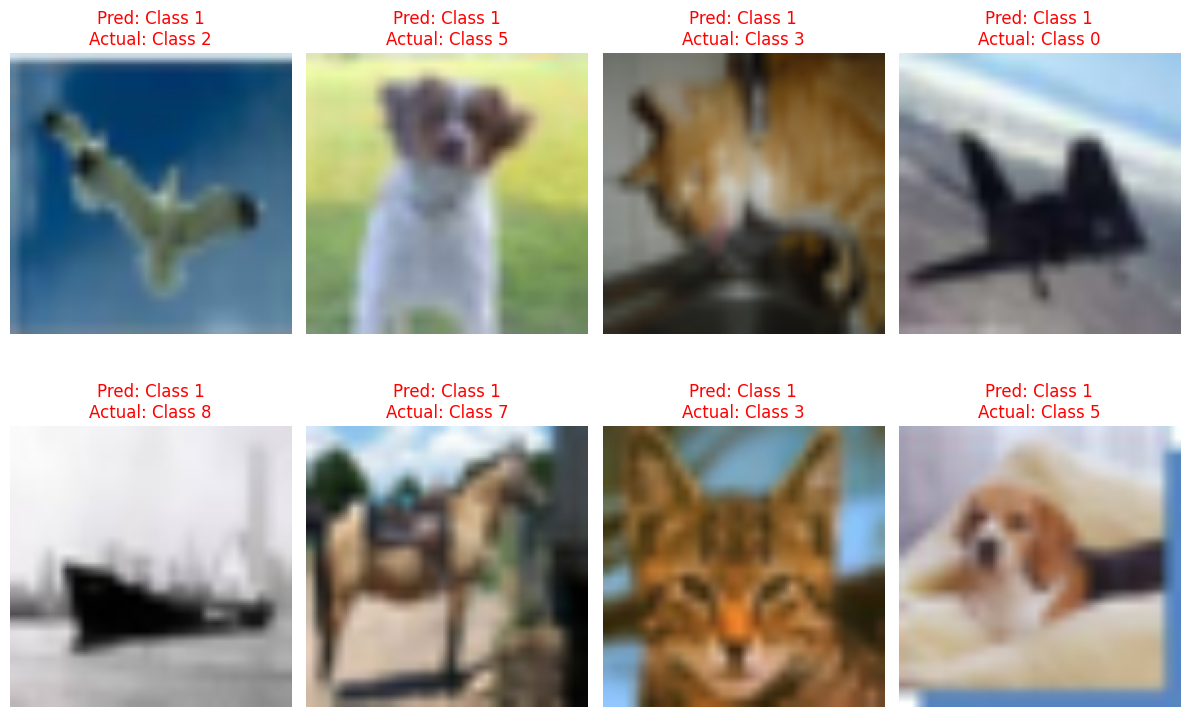

In [ ]:
import matplotlib.pyplot as plt
import torchvision.transforms.functional as F

# ✅ Get a batch of test images & labels
inputs, labels = next(iter(test_dataloader))
inputs, labels = inputs.to(device), labels.to(device)

# ✅ Get model predictions
model.eval()
with torch.no_grad():
    outputs = model(inputs)
    predicted_labels = outputs.argmax(dim=-1)

# ✅ Get class names (Modify if not available in dataset)
if hasattr(test_dataloader.dataset, "classes"):
    class_names = test_dataloader.dataset.classes  # Auto-detect class names
else:
    class_names = [f"Class {i}" for i in range(outputs.shape[1])]  # Default numbering

# ✅ Define number of images to display
num_images = min(8, inputs.shape[0])  # Show max 8 images
rows = (num_images + 3) // 4  # Adjust rows dynamically (2 rows if num_images > 4)

plt.figure(figsize=(12, rows * 4))

for i in range(num_images):
    plt.subplot(rows, 4, i + 1)  # Adjust subplot grid dynamically

    img = inputs[i].cpu()
    if img.shape[0] == 1:  # Handle grayscale images
        img = img.expand(3, -1, -1)

    img = F.to_pil_image(img)  # Convert tensor to PIL image
    plt.imshow(img)

    pred, actual = predicted_labels[i].item(), labels[i].item()
    color = "green" if pred == actual else "red"
    plt.title(f"Pred: {class_names[pred]}\nActual: {class_names[actual]}", color=color, fontsize=12)

    plt.axis("off")

plt.tight_layout()
plt.show()
